# DATASET
Dataset contains 6 tile  with different images
## LEGEND
the labels are:
- Building (#3C1098)
- Land (#8429F6)
- Road (#6EC1E4)
- Vegetation (#FEDD3A)
- Water (#E2A929)
- Unlabeled (#9B9B9B)

they are encoded in exadecimal
### SOURCE
from: https://www.kaggle.com/humansintheloop/semantic-segmentation-of-aerial-imagery
'''

In [ ]:
!pip install -r /content/requirements.txt

In [ ]:
!pip install kaggle

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
!mkdir -p ~/ .kaggle

In [10]:
!cp -r /content/drive/MyDrive/kaggle.json ~/ .kaggle/

In [11]:
!chmod 600 ~/ .kaggle/kaggle.json

In [12]:
!kaggle datasets download -d humansintheloop/semantic-segmentation-of-aerial-imagery

Dataset URL: https://www.kaggle.com/datasets/humansintheloop/semantic-segmentation-of-aerial-imagery
License(s): CC0-1.0
 95% 28.0M/29.6M [00:02<00:00, 22.0MB/s]
100% 29.6M/29.6M [00:02<00:00, 13.0MB/s]


In [ ]:
!unzip /content/semantic-segmentation-of-aerial-imagery.zip

In [14]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm


Segmentation Models: using `tf.keras` framework.


In [15]:
import tensorflow as tf
print(tf.__version__)
tf.random.set_seed(42)

2.12.1


In [16]:
PATH  = "/content/Semantic segmentation dataset"

In [18]:
from SemanticSegmentation_scripts.PatchesGenerator import PatchesGenerator
PATCH_GENERATOR = PatchesGenerator(256,PATH)
PATCH_GENERATOR.crop_image_creating()
PATCH_GENERATOR.crop_mask_creating()

In [ ]:
#PATCH_GENERATOR.image_dataset

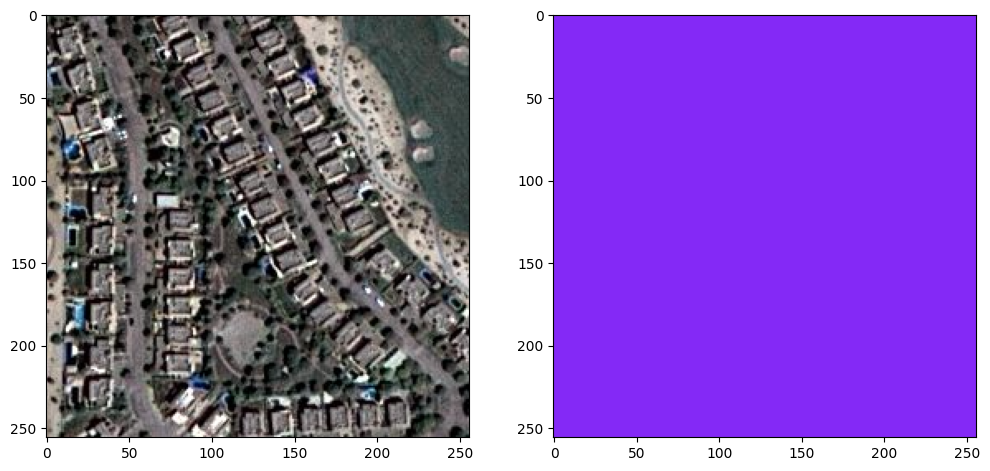

In [19]:
PATCH_GENERATOR.check()

In [20]:
from SemanticSegmentation_scripts.HEX_to_RGB import HEX_to_RGB,RGB_to_2DLabels

In [21]:
RGB_CONVERTOR = HEX_to_RGB()
HEXLabels = ["#3C1098", "#8429F6", "#6EC1E4", "#FEDD3A", "#E2A929","#9B9B9B"]
LabelsList = []
for el in HEXLabels:
    LabelsList.append(RGB_CONVERTOR.convert(el))

In [22]:
LabelsList

[array([ 60,  16, 152]),
 array([132,  41, 246]),
 array([110, 193, 228]),
 array([254, 221,  58]),
 array([226, 169,  41]),
 array([155, 155, 155])]

In [23]:
LABEL_CONVERTOR = RGB_to_2DLabels(LabelsList)
mask_dataset = PATCH_GENERATOR.mask_dataset
image_dataset = PATCH_GENERATOR.image_dataset

In [24]:
labels = []
for i in range(mask_dataset.shape[0]):
    label = LABEL_CONVERTOR.convert(mask_dataset[i])
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [25]:
print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1 2 3 4 5]


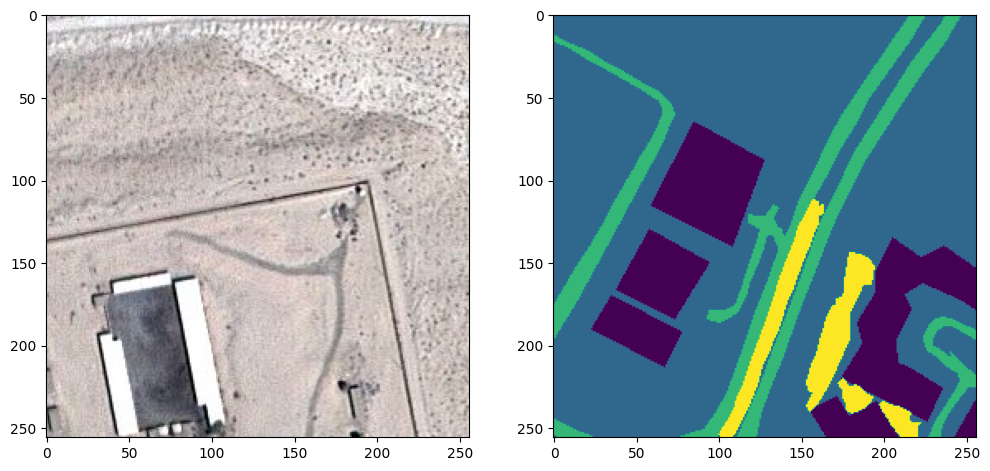

In [26]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# Modelling section

In [27]:
n_classes = len(np.unique(labels))
from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

## NEXT STEPS:

- Grid search for hyperparameter tuning following university procedure;
- review U-net concepts
- compare with other pretrained models


# Choosing hyperparameters

1. Check initial Loss (Turn off weight decay, sanity check loss at initialization)
2. Overfit a small sample (try to train to 100% training accuracy on a small sample of training data, approx. 5-10 minibatches)
    1. Fiddle with architecture, learning rate, weight initialization;
    2. some common problems:
        1. Loss is not going down: LR too low, or bad initialization;
        2. Loss explodes to Inf or Nan: LR too high, bad initialization
3. Use all the training data, turn on small weight decay, find the learning rate that makes the loss drop significantly  withing 100 iterations ( use the same architecture obtained in the previous step);
    1. good learning rates to try: 1e-1, 1e-2, 1e-3, 1e-4
4. choose few values of learning rate and weight decay around what worked for the previous step and then train these few models for 1-5 epochs
    1. good weight decay to try: 1e-4, 1e-5, 0
5. Pick the best models from Step 4, train them for longer 10-20 epochs WITHOUT learning rate decay.
6. Measure their performances using loss and accuracy curves
7. Go back to step 5 if needed (refine grid search)

In [29]:
import wandb
#wandb.login()
#!wandb login()
# https://docs.wandb.ai/quickstart

In [30]:
_, sample_imgs, y_, sample_labels = train_test_split(X_train, y_train, test_size = 0.005, random_state = 42)

In [31]:
from SemanticSegmentation_scripts.Multi_unet_model import multi_unet_model, jacard_coef

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


1. Check initial loss

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history1 = model.fit(X_train, y_train,
                    batch_size = 32,
                    verbose=1,
                    epochs=1,
                    shuffle=False)

33/33 [==============================] - 60s 2s/step - loss: 0.0474 - accuracy: 0.3261


2. Overfit a small sample

In [ ]:
sample_imgs.shape

(6, 256, 256, 3)

In [ ]:
model = multi_unet_model()
model.compile(optimizer='adam', loss=sm.losses.CategoricalFocalLoss(), metrics=["accuracy"])
history2 = model.fit(sample_imgs, sample_labels,
                    batch_size = 32,
                    verbose=1,
                    epochs=1000,
                    shuffle=False)

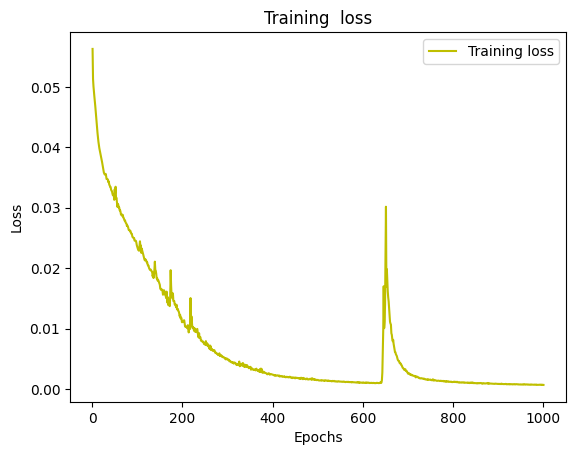

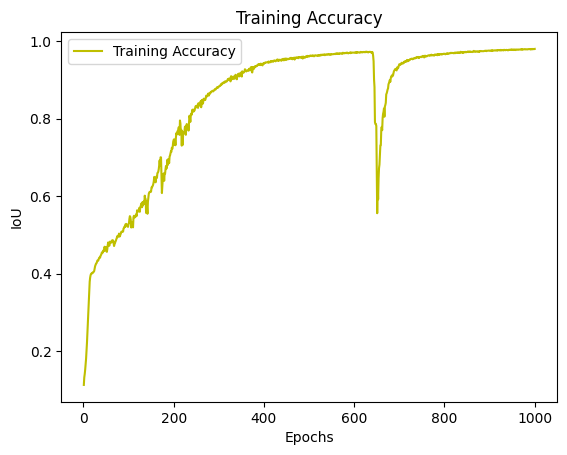

In [ ]:
history = history2
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.title('Training  loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

3. Grid-Search (for 100 iterations)

In [32]:
#from sklearn.model_selection import GridSearchCV
#from scikeras.wrappers import KerasClassifier

In [33]:
X_train.shape

(1044, 256, 256, 3)

In [34]:
import math
# dividing by 2 due to the cv
num_samples = 1044
batch_size = 32

# Calculate the number of epochs to reach the total iterations
batches_per_epoch = math.ceil(num_samples / batch_size) # this is equal to the number of iteration in a epoch
batches_per_epoch

27

In [35]:
total_iterations = 100
epochs = math.ceil(total_iterations / batches_per_epoch)
epochs

4

In [41]:
# Function used for Grid-search
def define_model(optimizer):
    model = multi_unet_model()
    model.compile(optimizer = optimizer, loss=sm.losses.CategoricalFocalLoss(), metrics=['accuracy'])
    return model


We can't use keras wrapper and grid search here due to shape constraints.

In fact, it is thought for 1D input/output.

We need to do sth else here!
https://adriangb.com/scikeras/stable/notebooks/DataTransformers.html

In [ ]:
#optimizer = ['Adam']
#param_grid = dict(optimizer=["adam"],
                  )
#model = KerasClassifier(model= define_model, optimizer="adam", epochs= 6,input_shape=(256, 256, 3),num_classes=6)

#grid = GridSearchCV(estimator=model, param_grid=param_grid,  verbose = 1, n_jobs=1, cv=2, error_score='raise')

#grid_result = grid.fit(X_train, y_train)

In [ ]:
# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
 #   print("Mean = %f (std=%f) with: %r" % (mean, stdev, param))

Then, using all the training data we perform a grid search.
The goal is to find the set of hyperparameters that has the loss drop significantly in 100 iterations.

Manually, the model is fit and then tested for evaluation!

In [ ]:
import gc
import wandb
# WandbCallback will automatically log history data from any metrics collected by keras: loss and anything passed into keras_model.compile().
from wandb.integration.keras import WandbCallback
from sklearn.model_selection import ParameterGrid

param_grid = {
    'optimizer': ["adam"],
    'optimizer__learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    #'epochs': [5, 10],
    #'batch_size': [16, 32]
}

results = []
NAME = "GRID_SEARCH_"
for params in ParameterGrid(param_grid):
    print("Training with params:", params)

    #########################################################################################
    wandb.init(project="FirstGridSearch",
               name = NAME + str(params),
               reinit=True,
               )
    #########################################################################################
    if params["optimizer"] == "adam":
      optimizer = tf.keras.optimizers.Adam(learning_rate=params['optimizer__learning_rate'])
    #########################################################################################
    model = define_model(optimizer=optimizer)
    # Fit the model
    model.fit(X_train, y_train, epochs=4, batch_size=32, verbose=1,callbacks=[WandbCallback()])
    wandb.finish()
    #########################################################################################

    # Clear the Keras/TensorFlow session to free up resources
    tf.keras.backend.clear_session()
    gc.collect()

# Print  the current results
for result in results:
    print("Parameters:", result['params'])
    print("Score:", result['score'])


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.1}


accuracy,▁▆▇█
epoch,▁▃▆█
loss,█▃▂▁
accuracy,0.48587
epoch,3
loss,0.03938


Epoch 1/4
33/33 [==============================] - 59s 2s/step - loss: 0.3040 - accuracy: 0.5242
Epoch 2/4
33/33 [==============================] - 55s 2s/step - loss: 0.3141 - accuracy: 0.5322
Epoch 3/4
33/33 [==============================] - 55s 2s/step - loss: 0.3141 - accuracy: 0.5322
Epoch 4/4
33/33 [==============================] - 55s 2s/step - loss: 0.3141 - accuracy: 0.5322


accuracy,▁███
epoch,▁▃▆█
loss,▁███
accuracy,0.53225
epoch,3
loss,0.31414


wandb: Currently logged in as: boesso-simone (simboex). Use `wandb login --relogin` to force relogin


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.01}


Epoch 1/4
33/33 [==============================] - 59s 2s/step - loss: 0.0501 - accuracy: 0.5133
Epoch 2/4
33/33 [==============================] - 56s 2s/step - loss: 0.0341 - accuracy: 0.5322
Epoch 3/4
33/33 [==============================] - 55s 2s/step - loss: 0.0338 - accuracy: 0.5322
Epoch 4/4
33/33 [==============================] - 55s 2s/step - loss: 0.0336 - accuracy: 0.5329


accuracy,▁███
epoch,▁▃▆█
loss,█▁▁▁
accuracy,0.53291
epoch,3
loss,0.03363


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.001}


Epoch 1/4
33/33 [==============================] - 59s 2s/step - loss: 0.0488 - accuracy: 0.4100
Epoch 2/4
33/33 [==============================] - 55s 2s/step - loss: 0.0401 - accuracy: 0.5301
Epoch 3/4
33/33 [==============================] - 55s 2s/step - loss: 0.0372 - accuracy: 0.5302
Epoch 4/4
33/33 [==============================] - 56s 2s/step - loss: 0.0356 - accuracy: 0.5291


accuracy,▁███
epoch,▁▃▆█
loss,█▃▂▁
accuracy,0.52915
epoch,3
loss,0.0356


Training with params: {'optimizer': 'adam', 'optimizer__learning_rate': 0.0001}


Epoch 1/4
33/33 [==============================] - 59s 2s/step - loss: 0.0420 - accuracy: 0.4519
Epoch 2/4
 1/33 [..............................] - ETA: 53s - loss: 0.0402 - accuracy: 0.5180